<a href="https://colab.research.google.com/github/eddiechn/Multi-Class-Animal-Classification/blob/main/Multi_Animal_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
ad23274e4c18b2822f27b09300d81ae6

In [1]:
# import libraries - data science
import numpy as np
import pandas as pd
import tensorflow as tf
import random


# import libraries - visualization
import matplotlib.pyplot as plt

# import libraries - system
import os
from pathlib import Path


In [3]:
!pip install opendatasets

In [2]:
# data
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [4]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/alessiocorrado99/animals10/data?select=raw-img')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: eddiechn1
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10


100%|██████████| 586M/586M [00:07<00:00, 82.8MB/s]


In [3]:
import sys
sys.path.append('/content/animals10') ## sys.path list of directories to look at when import is invoked

sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/animals10']

In [4]:
from translate import translate
print(translate)

{'cane': 'dog', 'cavallo': 'horse', 'elefante': 'elephant', 'farfalla': 'butterfly', 'gallina': 'chicken', 'gatto': 'cat', 'mucca': 'cow', 'pecora': 'sheep', 'scoiattolo': 'squirrel', 'dog': 'cane', 'elephant': 'elefante', 'butterfly': 'farfalla', 'chicken': 'gallina', 'cat': 'gatto', 'cow': 'mucca', 'spider': 'ragno', 'squirrel': 'scoiattolo'}


In [5]:
dataset_dir = 'animals10/raw-img'

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE,
    label_mode='int'
)

Found 26179 files belonging to 10 classes.


In [17]:
total_files = sum(1 for _ in dataset.unbatch())
total_files

26179

In [ ]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [9]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

In [10]:
directory = Path(dataset_dir)
for animal in directory.iterdir():
  if animal.is_dir():
    for img in animal.iterdir():
      try:
          PIL.Image.open(img)
      except UnidentifiedImageError:
          os.remove(img)

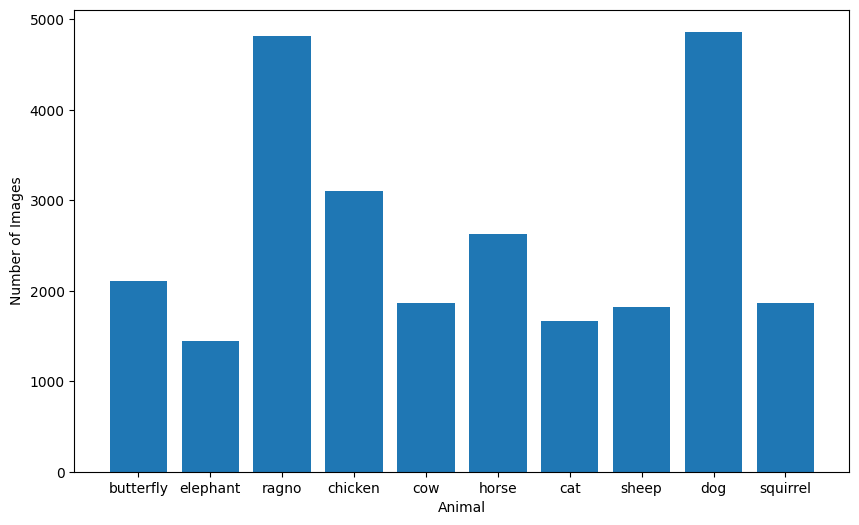

In [ ]:
# distrbution
image_counts = {}
for animal in directory.iterdir():
  if animal.is_dir():
    image_counts[animal.name] = len(list(animal.iterdir()))

labels = [translate.get(animal, animal) for animal in image_counts.keys()]

plt.figure(figsize=(10, 6))
plt.bar(labels, image_counts.values())
plt.xlabel('Animal')
plt.ylabel('Number of Images')
plt.show()

In [12]:
def get_random_animal(dataset, num_images):
    all_images = []
    all_labels = []
    for images, labels in dataset.take(10):
        all_images.extend(images.numpy())  # Convert tensors to numpy arrays
        all_labels.extend(labels.numpy())  # Convert tensors to numpy arrays

    random_indices = np.random.choice(len(all_images), num_images, replace=False)
    selected_images = [all_images[i] for i in random_indices]
    selected_labels = [all_labels[i] for i in random_indices]

    return selected_images, selected_labels

In [18]:
label_mapping = {
    0: 'dog',
    1: 'horse',
    2: 'elephant',
    3: 'butterfly',
    4: 'chicken',
    5: 'cat',
    6: 'cow',
    7: 'sheep',
    8: 'spider',
    9: 'squirrel'
}

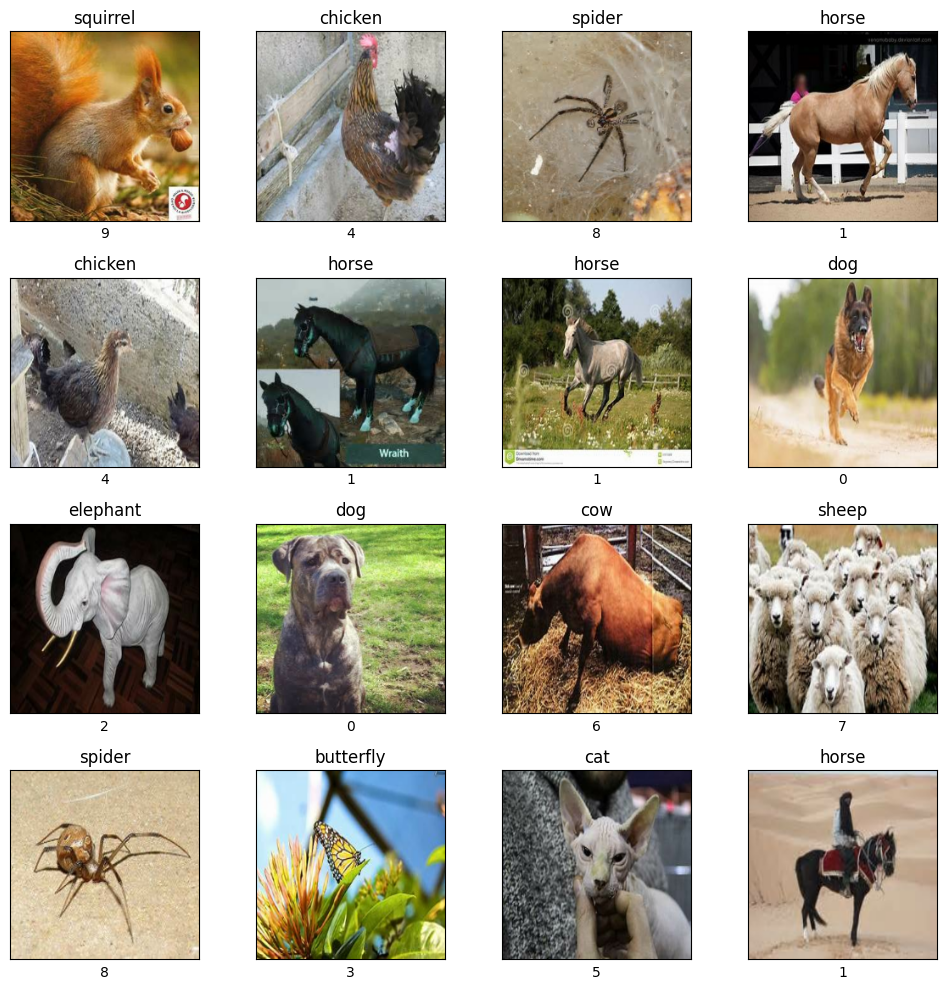

In [14]:
images, labels = get_random_animal(dataset, 16)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].astype('int'))
    ax.set_title(label_mapping[labels[i]])
    ax.set_xlabel(labels[i])

plt.tight_layout()
plt.show()

Preprocessing

In [7]:
VALIDATION_SPLIT = 0.2  # 20% of data for validation
TEST_SPLIT = 0.1  # 10% of data for testing (from the original dataset)

In [20]:
tf.data.experimental.cardinality(dataset).numpy()

819

In [35]:
def split_dataset(dataset, val_split=0.2, test_split=0.1, seed=42):
    # Calculate split sizes
    train_size = int(tf.data.experimental.cardinality(dataset).numpy()  * (1 - (val_split + test_split)))
    val_size = int(tf.data.experimental.cardinality(dataset).numpy() * val_split)
    test_size = int(tf.data.experimental.cardinality(dataset).numpy() * test_split)


    print(f"Train size: {train_size}")
    print(f"Validation size: {val_size}")
    print(f"Test size: {test_size}")

    # Split the dataset
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset


In [36]:
train_dataset, val_dataset, test_dataset = split_dataset(dataset)

Train size: 573
Validation size: 163
Test size: 81


In [37]:
tf.data.experimental.cardinality(dataset)

<tf.Tensor: shape=(), dtype=int64, numpy=819>

In [40]:
# automatic tuning of some parameters. prefetching. improves performance

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [41]:
for images, labels in train_dataset:
    print(f"Train images shape: {images.shape}")
    print(f"Train labels shape: {labels.shape}")
    break

Train images shape: (32, 224, 224, 3)
Train labels shape: (32,)


Train the model

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Rescaling

In [44]:
num_classes = 10
IMG_SIZE = (224, 224)

In [45]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=(224, 224, 3)))
model.add(Conv2D(32, (3,3), 1,  activation='relu' ))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [46]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0

In [48]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [49]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [51]:
hist = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[tensorboard_callback])

Epoch 1/10
573/573 [==============================] - 67s 108ms/step - loss: 1.7918 - accuracy: 0.4126 - val_loss: 1.4433 - val_accuracy: 0.5130
Epoch 2/10
573/573 [==============================] - 58s 100ms/step - loss: 1.0208 - accuracy: 0.6597 - val_loss: 1.3011 - val_accuracy: 0.5640
Epoch 3/10
573/573 [==============================] - 58s 101ms/step - loss: 0.4449 - accuracy: 0.8583 - val_loss: 1.5459 - val_accuracy: 0.5590
Epoch 4/10
573/573 [==============================] - 74s 128ms/step - loss: 0.1655 - accuracy: 0.9499 - val_loss: 2.0370 - val_accuracy: 0.5535
Epoch 5/10
573/573 [==============================] - 73s 128ms/step - loss: 0.0989 - accuracy: 0.9727 - val_loss: 2.2476 - val_accuracy: 0.5629
Epoch 6/10
573/573 [==============================] - 74s 128ms/step - loss: 0.0710 - accuracy: 0.9795 - val_loss: 2.6153 - val_accuracy: 0.5481
Epoch 7/10
573/573 [==============================] - 58s 100ms/step - loss: 0.0527 - accuracy: 0.9848 - val_loss: 2.8518 - val_ac

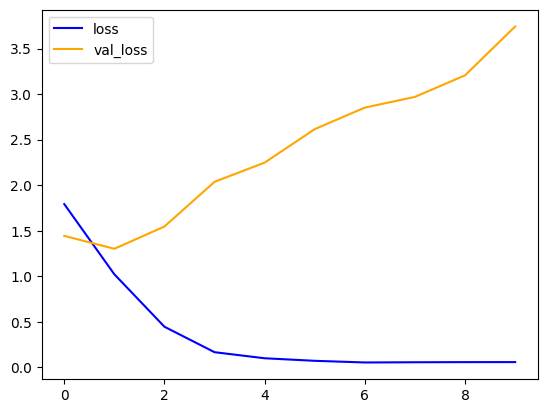

In [52]:
plot = plt.figure()
plt.plot(hist.history['loss'], color='blue', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.legend()
plt.show()

##Evaluating Model

In [72]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [73]:
precision = Precision()
recall = Recall()
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [ ]:
import tensorflow as tf

# Initialize metric objects
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()  # For integer labels

for batch in test_dataset.as_numpy_iterator():
    X, y = batch
    yhat_prob = model.predict(X)

    # Convert probabilities to class labels
    yhat = tf.argmax(yhat_prob, axis=1)

    # If y is one-hot encoded, convert it to class indices
    if y.ndim > 1:
        y = tf.argmax(y, axis=1)

    # Ensure shapes are compatible
    y = tf.squeeze(y)  # Remove any extra dimensions (e.g., shape (batch_size, 1) -> (batch_size,))
    yhat = tf.squeeze(yhat)  # Ensure yhat has shape (batch_size,)

    # Update metrics
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

# Calculate and print the final metric values
precision_result = precision.result().numpy()
recall_result = recall.result().numpy()
accuracy_result = accuracy.result().numpy()

print(f"Precision: {precision_result}")
print(f"Recall: {recall_result}")
print(f"Accuracy: {accuracy_result}")


In [67]:
precision_result = precision.result().numpy()
recall_result = recall.result().numpy()
accuracy_result = accuracy.result().numpy()

print(f"Precision: {precision_result}")
print(f"Recall: {recall_result}")
print(f"Accuracy: {accuracy_result}")

Precision: 0.8775709867477417
Recall: 0.8602976202964783
Accuracy: 0.0
